##### Copyright 2019 The TensorFlow Authors.

In [92]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](./images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](./images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [93]:
import tensorflow as tf

In [94]:
tf.__version__

'2.10.0'

In [95]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install PIL

  Cloning https://github.com/tensorflow/docs to c:\users\aidan\appdata\local\temp\pip-req-build-0w_pxoas


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [96]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import PIL as pillow

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [97]:
train_images = np.load('2d_data.npy')
train_labels = np.load('2d_label.npy')

In [98]:
print(train_images.shape)

(4455, 240, 240, 1)


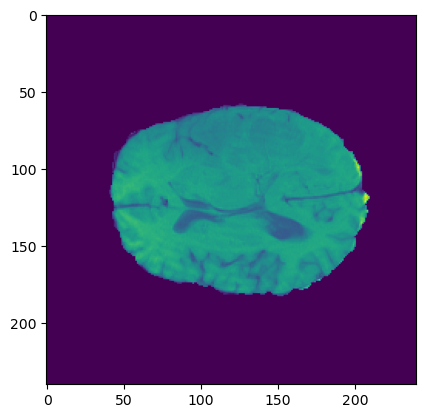

In [99]:
plt.imshow(train_images[30])

In [100]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [101]:
from sklearn import preprocessing

In [102]:
"""train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]"""

resized_training_images = np.zeros(shape=(train_images.shape[0], 60,60, 1))#train_images.shape[1]/2, train_images.shape[2]/2, 1))

for i in range(train_images.shape[0]):
    train_images[i] = train_images[i]/max(train_images[i].flatten()) #normalise images to [0,1] - possibly in the future change this to [-1, 1]
    resized_training_images[i] = train_images[i,::4,::4,:]

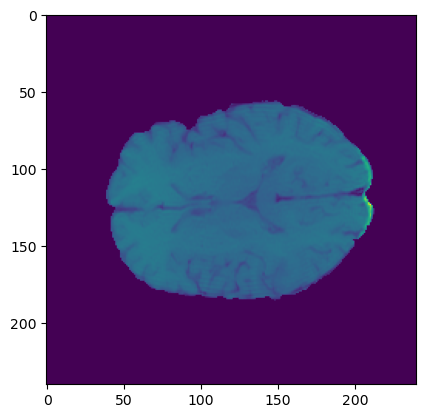

In [103]:
plt.imshow(train_images[0])

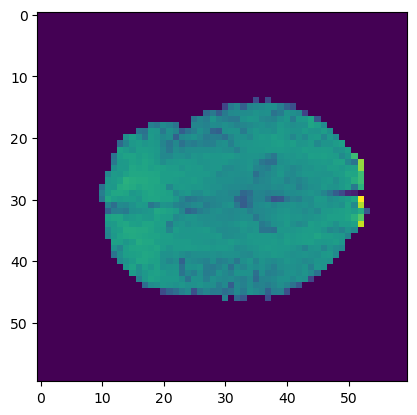

In [104]:
plt.imshow(resized_training_images[0])

In [105]:
BUFFER_SIZE = 4455
BATCH_SIZE = 100

In [106]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(resized_training_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [107]:
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 60, 60, 1), dtype=tf.float64, name=None)>


In [108]:
60*60

3600

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [109]:
"""def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*3600, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 3600)))
    assert model.output_shape == (None, 7, 7, 3600)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(1800, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 1800)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(900, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 900)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 60, 60, 1)

    return model"""

"def make_generator_model():\n    model = tf.keras.Sequential()\n    model.add(layers.Dense(7*7*3600, use_bias=False, input_shape=(100,)))\n    model.add(layers.BatchNormalization())\n    model.add(layers.LeakyReLU())\n\n    model.add(layers.Reshape((7, 7, 3600)))\n    assert model.output_shape == (None, 7, 7, 3600)  # Note: None is the batch size\n\n    model.add(layers.Conv2DTranspose(1800, (5, 5), strides=(1, 1), padding='same', use_bias=False))\n    assert model.output_shape == (None, 7, 7, 1800)\n    model.add(layers.BatchNormalization())\n    model.add(layers.LeakyReLU())\n\n    model.add(layers.Conv2DTranspose(900, (5, 5), strides=(2, 2), padding='same', use_bias=False))\n    assert model.output_shape == (None, 14, 14, 900)\n    model.add(layers.BatchNormalization())\n    model.add(layers.LeakyReLU())\n\n    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))\n    assert model.output_shape == (None, 60, 60, 1)\n\n    re

In [110]:
latent_dim = 100
def make_generator_model():
    model = tf.keras.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(15*15*128),
            layers.Reshape((15,15,128)),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(1, kernel_size=5, padding="same", activation='sigmoid'),
        ]
    )
    return model

make_generator_model().summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 28800)             2908800   
                                                                 
 reshape_10 (Reshape)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 30, 30, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 60, 60, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 60, 60, 256)     

In [111]:
noise = tf.random.normal([1, 100])
print(noise)

tf.Tensor(
[[-0.031876    1.7980492  -0.6794769   1.7255796   0.29344252 -0.9958389
   0.24909364  0.2512301  -0.10024856 -0.88118404 -2.0939522  -0.61897284
  -1.2827357  -1.1516391  -0.24304004  0.32821828 -0.9032014  -0.19062665
  -1.0956199  -0.25526333  0.6571846   1.3412291   0.69020903  1.2113049
   0.31181413  0.07095035  1.79706    -2.5468693   1.4664385   0.7465685
   0.50344706 -0.4186143   0.3250246   0.4593467   0.4943932   1.4658533
   0.52927303 -0.01298421  1.5147392  -0.04018418 -0.8312466  -0.26964158
  -0.05206661  0.07993844  0.9503854  -0.0155789  -0.04527217 -0.56963825
   0.36060357  0.8675308   0.3994789  -0.86619    -0.7604659   1.1894753
   1.376232    0.5653546   0.34094366  0.066412    1.5861748  -0.26550412
  -0.35852638  0.408061   -0.7567695  -1.7031763  -1.9371411   0.14014103
  -0.43798214  0.5391489   0.03557845  0.6446615   1.0765007  -0.21475305
  -1.4797566  -1.3910886   0.72690725  0.33695725 -0.3749998   0.7110825
  -0.6583981  -0.88643366  0.9191

Use the (as yet untrained) generator to create an image.

tf.Tensor(
[[-0.65083665  1.7283686  -1.7416228   0.19140626 -1.1049045   1.9468439
   0.79722303 -0.50433236  0.5641753  -0.03504946  2.9142616   0.54795194
   0.84564126  0.37759596 -1.0916554   1.059648    0.44857603  0.41665947
  -0.6028448  -1.3979579  -2.3407335  -0.14514203 -0.05714386 -0.08306381
   2.2682848  -0.63958555 -0.05235222  0.4696201  -0.5425987  -3.352675
  -0.11429584  0.18322347 -0.32098567  0.21537901  1.1127093  -0.5466014
  -0.27284834 -0.63278645 -0.37145332  0.7009849   1.2365613   0.35940352
  -0.33954796 -1.3622115   1.7620181  -0.6954752  -0.30247065 -1.0985758
  -0.1592456   0.4656349   0.61537087  0.7478819   0.17867649 -0.84441376
   1.0566939   1.7948524   0.9058355  -0.14673729 -0.39211702 -0.16033897
   1.345084    0.9396068   1.2517743  -0.2868803   0.24498156 -0.12531991
   0.25762585 -0.43007615  0.8865582   0.7981295   0.24942005  1.0558963
  -0.79901135  1.1101081   0.02257603 -0.6004603   0.60720533  0.03920035
   0.7901184  -0.03679034  0.4284

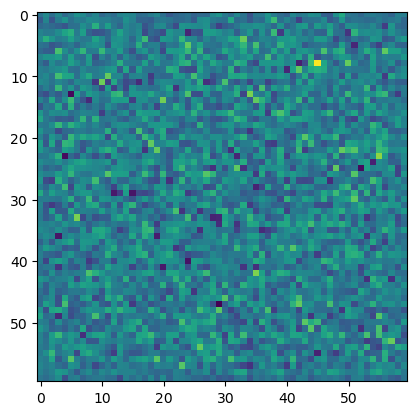

In [112]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(noise)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [113]:
"""def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model"""

def make_discriminator_model():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(60,60,1)),
            layers.Conv2D(60, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid'),
        ]
    )
    return model

make_discriminator_model().summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 60)        1020      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 30, 30, 60)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 120)       115320    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 15, 15, 120)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 120)         230520    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 8, 8, 120)         0         
                                                                 
 flatten_4 (Flatten)         (None, 7680)            

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [114]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4943018]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [115]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [116]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [117]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [118]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [119]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [120]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [121]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [122]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [123]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

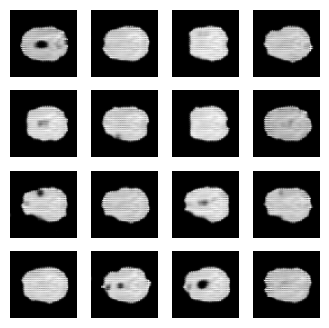

In [124]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [129]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [130]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

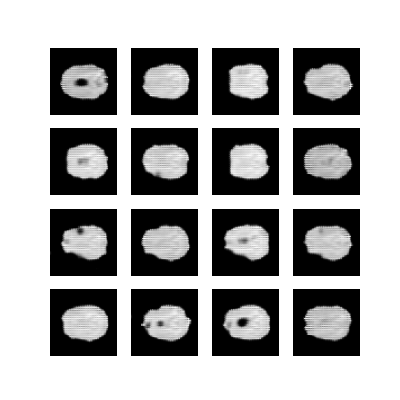

In [131]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [132]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\aidan\AppData\Local\Temp\ipykernel_18464\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\aidan\AppData\Local\Temp\ipykernel_18464\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [133]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
